In [1]:

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Robot leg configuration
upper_leg_length = 10.0
lower_leg_length = 10.0

body_length = 21.0
body_width = 15.8
max_height = 15.0

# Shoulder positions (static)
shoulder_positions = np.asfortranarray([
    [body_length / 2, body_length / 2, -body_length / 2, -body_length / 2],
    [-body_width / 2, body_width / 2, -body_width / 2, body_width / 2],
    [0, 0, 0, 0],
])



In [2]:

def inverse_kinematics(x: float, y: float, z: float, a1: float=upper_leg_length, a2: float=lower_leg_length):
    y_prime = -math.sqrt((z)**2 + y**2)
    thetaz = math.atan2(abs(y), z)

    c2 = (x**2 + y_prime**2 - a1**2 - a2**2) / (2 * a1 * a2)
    s2 = math.sqrt(abs(1 - c2**2))
    theta2 = math.atan2(s2, c2)

    c1 = (x * (a1 + (a2 * c2)) + y_prime * (a2 * s2)) / (x**2 + y_prime**2)
    s1 = (y_prime * (a1 + (a2 * c2)) - x * (a2 * s2)) / (x**2 + y_prime**2)
    theta1 = math.atan2(s1, c1)

    theta_shoulder = -theta1
    theta_elbow = theta_shoulder - theta2
    theta_hip = thetaz

    return math.degrees(theta_shoulder), math.degrees(theta_elbow), math.degrees(theta_hip)


In [3]:

def compensate_foot_positions_by_gyro(np_foot_positions, roll, pitch):
    roll_rad = math.radians(roll)
    pitch_rad = math.radians(pitch)
    body_normal = np.array([
        math.sin(roll_rad),
        -math.sin(pitch_rad) * math.cos(roll_rad),
        math.cos(pitch_rad) * math.cos(roll_rad)
    ])

    base_correction = 0.8
    severity = max(
        min(abs(roll) / 45.0, 1.0),
        min(abs(pitch) / 45.0, 1.0)
    )
    correction_factor = base_correction * (1.0 + severity)

    max_compensation = 3.0
    max_leg_extension_y = -max_height * 1.2
    min_leg_extension_y = -max_height * 0.5

    compensated_positions = np_foot_positions.copy()
    for i in range(4):
        dx = shoulder_positions[0, i]
        dy = shoulder_positions[1, i]
        height_adj = (dx * body_normal[0] + dy * body_normal[1]) * correction_factor
        height_adj = np.clip(height_adj, -max_compensation, max_compensation)

        new_height = compensated_positions[2, i] - height_adj
        if new_height < max_leg_extension_y:
            height_adj = compensated_positions[2, i] - max_leg_extension_y
        elif new_height > min_leg_extension_y:
            height_adj = compensated_positions[2, i] - min_leg_extension_y

        compensated_positions[2, i] -= height_adj

    return compensated_positions


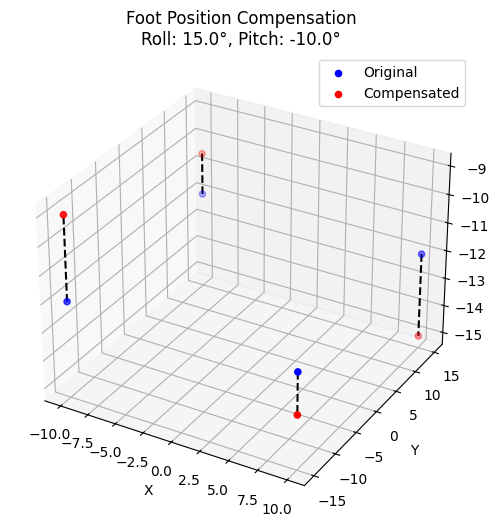

In [4]:

# Synthetic flat stance
original_positions = np.array([
    [ 10.0,  10.0, -10.0, -10.0],  # x
    [-15.0,  15.0, -15.0,  15.0],  # y
    [-12.0, -12.0, -12.0, -12.0]   # z
])

# Simulate gyro data
roll_angle = 15.0
pitch_angle = -10.0

compensated = compensate_foot_positions_by_gyro(original_positions, roll=roll_angle, pitch=pitch_angle)

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*original_positions, color='blue', label='Original')
ax.scatter(*compensated, color='red', label='Compensated')

for i in range(4):
    ax.plot([original_positions[0, i], compensated[0, i]],
            [original_positions[1, i], compensated[1, i]],
            [original_positions[2, i], compensated[2, i]], 'k--')

ax.set_title(f"Foot Position Compensation\nRoll: {roll_angle}°, Pitch: {pitch_angle}°")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.grid(True)
plt.show()


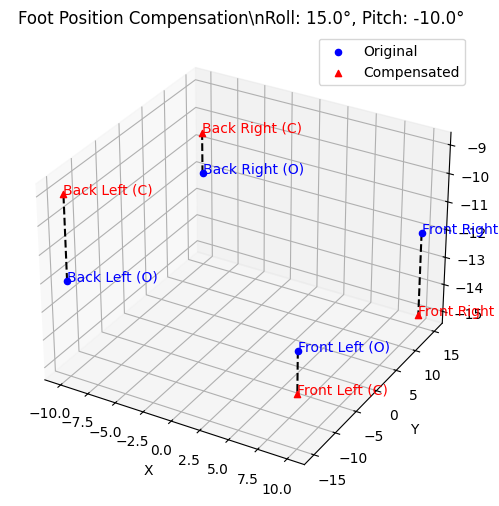

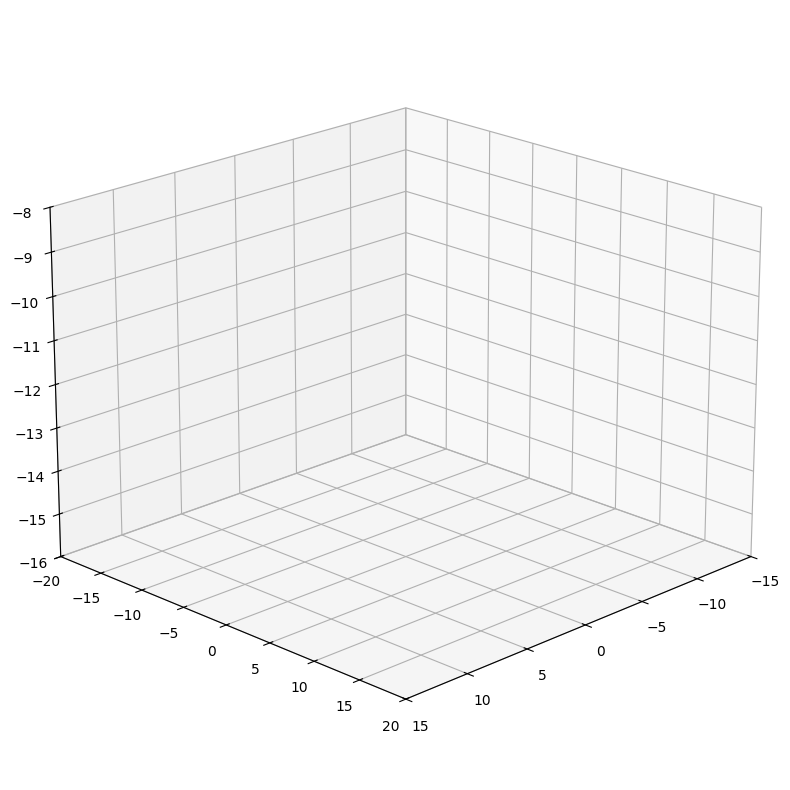

In [8]:
# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Colors for each leg
colors = ['blue', 'green', 'purple', 'orange']
labels = ['Front Left', 'Front Right', 'Back Left', 'Back Right']

# Plot each leg's original and compensated point
for i in range(4):
    ax.scatter(original_positions[0, i], original_positions[1, i], original_positions[2, i],
               color='blue', label='Original' if i == 0 else "", marker='o')
    ax.scatter(compensated[0, i], compensated[1, i], compensated[2, i],
               color='red', label='Compensated' if i == 0 else "", marker='^')

    # Connect with dashed line
    ax.plot([original_positions[0, i], compensated[0, i]],
            [original_positions[1, i], compensated[1, i]],
            [original_positions[2, i], compensated[2, i]],
            'k--')

    # Add labels
    ax.text(original_positions[0, i], original_positions[1, i], original_positions[2, i],
            f"{labels[i]} (O)", color='blue')
    ax.text(compensated[0, i], compensated[1, i], compensated[2, i],
            f"{labels[i]} (C)", color='red')

ax.set_title(f"Foot Position Compensation\\nRoll: {roll_angle}°, Pitch: {pitch_angle}°")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-15, 15)
ax.set_ylim(-20, 20)
ax.set_zlim(-16, -8)
ax.view_init(elev=20, azim=45)
ax.grid(True)
plt.tight_layout()
plt.show()

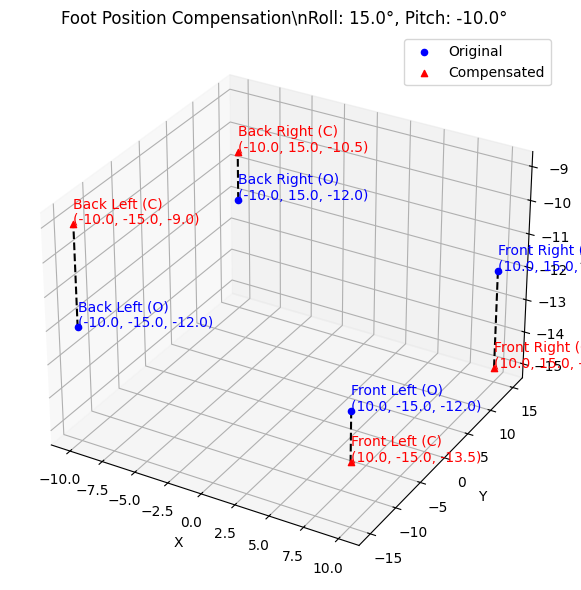

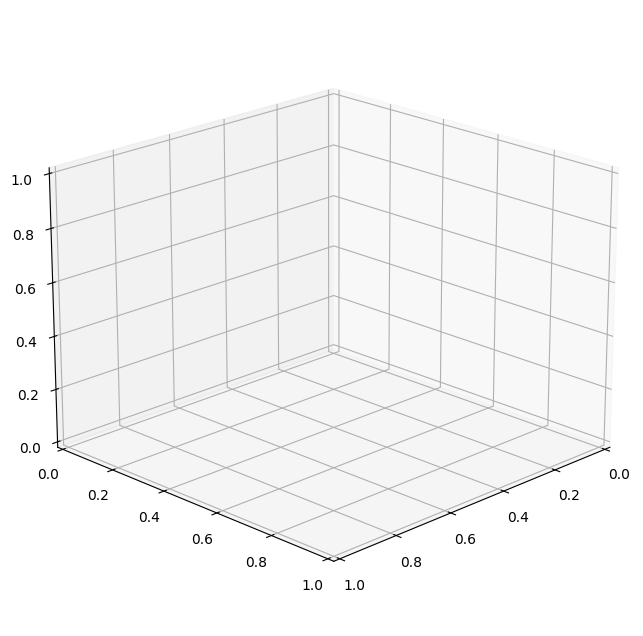

In [18]:
# Plotting
fig = plt.figure(figsize=(20, 6))
ax.view_init(elev=40, azim=1)  # Adjust elevation and azimuth
ax = fig.add_subplot(111, projection='3d')

# Colors for each leg
colors = ['blue', 'green', 'purple', 'orange']
labels = ['Front Left', 'Front Right', 'Back Left', 'Back Right']

# Plot each leg's original and compensated point
for i in range(4):
    # Original point
    ox, oy, oz = original_positions[:, i]
    ax.scatter(ox, oy, oz, color='blue', label='Original' if i == 0 else "", marker='o')
    ax.text(ox, oy, oz, f"{labels[i]} (O)\n({ox:.1f}, {oy:.1f}, {oz:.1f})", color='blue')

    # Compensated point
    cx, cy, cz = compensated[:, i]
    ax.scatter(cx, cy, cz, color='red', label='Compensated' if i == 0 else "", marker='^')
    ax.text(cx, cy, cz, f"{labels[i]} (C)\n({cx:.1f}, {cy:.1f}, {cz:.1f})", color='red')

    # Dashed line between original and compensated
    ax.plot([ox, cx], [oy, cy], [oz, cz], 'k--')

# Labels and settings
ax.set_title(f"Foot Position Compensation\\nRoll: {roll_angle}°, Pitch: {pitch_angle}°")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.grid(True)
plt.tight_layout()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=45)
plt.show()

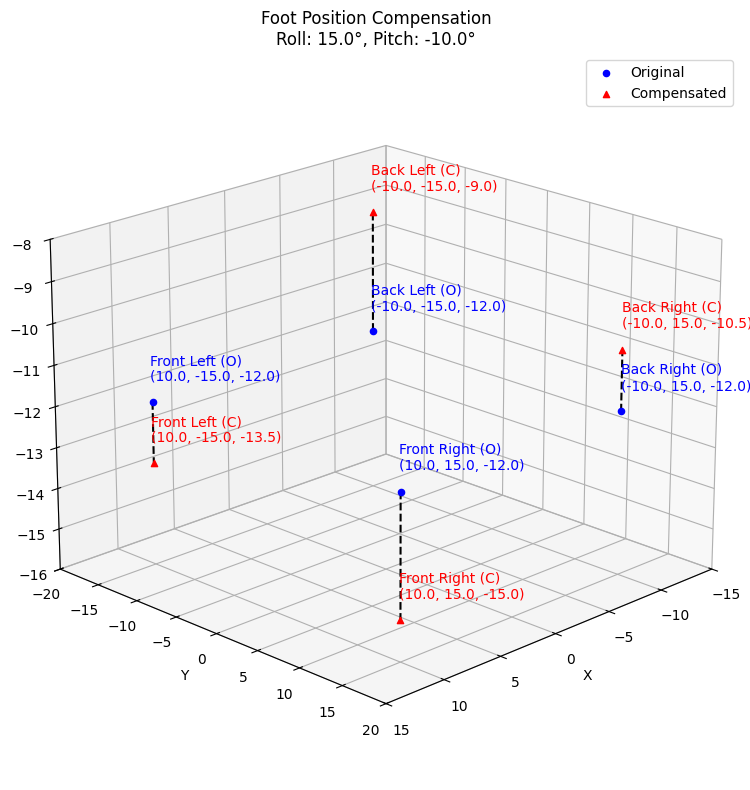

In [19]:
# === Apply gyro compensation ===
roll_angle = 15.0
pitch_angle = -10.0
compensated = compensate_foot_positions_by_gyro(original_positions, roll=roll_angle, pitch=pitch_angle)

# === Plotting ===
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Set custom axis limits and view angle
ax.set_xlim(-15, 15)
ax.set_ylim(-20, 20)
ax.set_zlim(-16, -8)
ax.view_init(elev=20, azim=45)

# Leg labels
labels = ['Front Left', 'Front Right', 'Back Left', 'Back Right']
offset = 0.6

# Plot all four legs
for i in range(4):
    ox, oy, oz = original_positions[:, i]
    cx, cy, cz = compensated[:, i]

    # Plot original and compensated points
    ax.scatter(ox, oy, oz, color='blue', marker='o', label='Original' if i == 0 else "")
    ax.scatter(cx, cy, cz, color='red', marker='^', label='Compensated' if i == 0 else "")

    # Connect with a dashed line
    ax.plot([ox, cx], [oy, cy], [oz, cz], 'k--')

    # Label with coordinates
    ax.text(ox + offset, oy + offset, oz + offset, f"{labels[i]} (O)\n({ox:.1f}, {oy:.1f}, {oz:.1f})", color='blue')
    ax.text(cx + offset, cy + offset, cz + offset, f"{labels[i]} (C)\n({cx:.1f}, {cy:.1f}, {cz:.1f})", color='red')

# Final decorations
ax.set_title(f"Foot Position Compensation\nRoll: {roll_angle}°, Pitch: {pitch_angle}°")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [21]:
def polygon_area_3d(points: np.ndarray) -> float:
    """
    Calculate the area of a polygon in 3D space using vector cross products.
    Assumes the points form a simple, non-intersecting polygon in order.
    points: np.ndarray of shape (N, 3) - list of 3D vertices in order
    """
    if points.shape[0] < 3:
        return 0.0

    # Choose the first point as reference
    ref = points[0]
    area = 0.0
    for i in range(1, len(points) - 1):
        v1 = points[i] - ref
        v2 = points[i + 1] - ref
        cross_prod = np.cross(v1, v2)
        triangle_area = 0.5 * np.linalg.norm(cross_prod)
        area += triangle_area
    return area


# 4 points forming a tilted rectangle
foot_points = np.array([
    [ 10.0, -15.0, -13.5],  # Front Left
    [ 10.0,  15.0, -15.0],  # Front Right
    [-10.0, -15.0,  -9.0],  # Back Left
    [-10.0,  15.0, -10.5],  # Back Right
])

area = polygon_area_3d(foot_points)
print(f"3D polygon area: {area:.3f} units²")

3D polygon area: 615.731 units²


,time,roll,pitch,yaw,FL_ELBOW,FR_ELBOW,BL_ELBOW,BR_ELBOW
0,0,-0.5629,-5.0092,0.0666,-8.94187,-9.05445,-10.94555,-11.05813
1,1,-0.6124,-5.0091,0.0758,-8.93694,-9.05942,-10.94058,-11.06306
2,2,-0.6621,-5.0020,0.0919,-8.93339,-9.06581,-10.93419,-11.06661
3,3,-0.7045,-4.9949,0.1007,-8.93057,-9.07147,-10.92853,-11.06943
4,4,-0.7469,-4.9878,0.1095,-8.92775,-9.07713,-10.92287,-11.07225
...,...,...,...,...,...,...,...,...
61,61,-3.0594,-4.6927,1.1898,-8.75552,-9.36740,-10.63260,-11.24448
62,62,-3.0668,-4.7512,1.3528,-8.74308,-9.35644,-10.64356,-11.25692
63,63,-3.0599,-4.7653,1.3528,-8.74095,-9.35293,-10.64707,-11.25905
64,64,-3.0604,-4.7579,1.3667,-8.74238,-9.35446,-10.64554,-11.25762


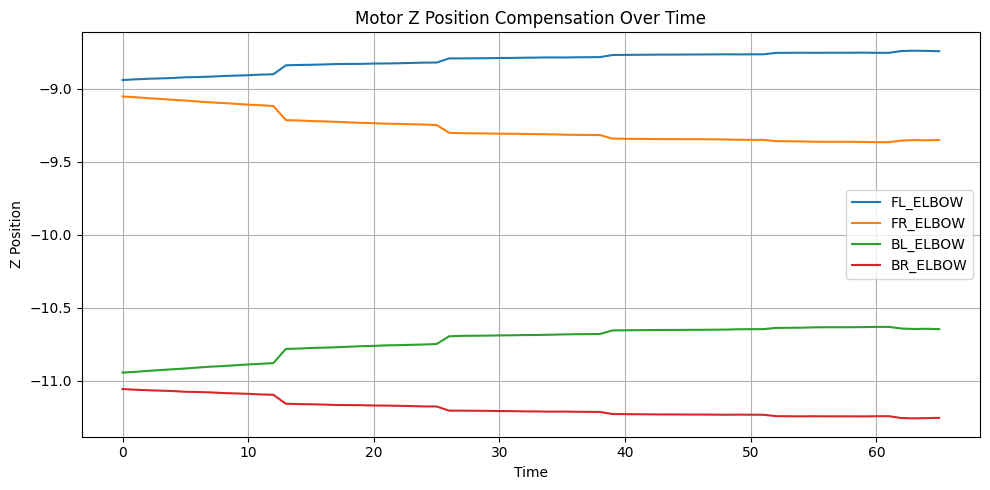

In [13]:
# --- Imports and Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

# --- Data Models ---
@dataclass
class GyroData:
    roll: float  # Rotation around X (forward)
    pitch: float  # Rotation around Y (side)
    yaw: float  # Rotation around Z (vertical)

@dataclass
class MotorState:
    name: str
    z_position: float

# --- Constants ---
MOTOR_NAMES = [
    "FL_ELBOW", "FR_ELBOW", "BL_ELBOW", "BR_ELBOW"
]

# --- Coordinate Frame Agreement ---
# Assume:
#   X (roll): forward
#   Y (pitch): left
#   Z (yaw): up
# Motors control Z height
#   - Pitch forward = lower front, raise back
#   - Roll right = raise left, lower right

# --- Motor Initialization ---
def init_motor_states():
    return {name: MotorState(name, -10.0) for name in MOTOR_NAMES}

# --- Gyroscope Compensation Logic ---
def compensate_motors(gyro: GyroData, motors: dict, pitch_gain=0.2, roll_gain=0.1):
    updated = {}
    for name, state in motors.items():
        z = state.z_position
        
        if name.startswith("FL") or name.startswith("FR"):
            z -= pitch_gain * gyro.pitch  # lower front for forward pitch
        if name.startswith("BL") or name.startswith("BR"):
            z += pitch_gain * gyro.pitch  # raise back for forward pitch

        if name.startswith("FL") or name.startswith("BL"):
            z -= roll_gain * gyro.roll   # lower left for right roll
        if name.startswith("FR") or name.startswith("BR"):
            z += roll_gain * gyro.roll   # raise right for right roll

        updated[name] = MotorState(name, z)
    return updated

# --- Simulate Gyro Inputs ---
gyro_data_samples = [
    GyroData(-0.5629, -5.0092, 0.0666), GyroData(-0.6124, -5.0091, 0.0758), GyroData(-0.6621, -5.0020, 0.0919),
    GyroData(-0.7045, -4.9949, 0.1007), GyroData(-0.7469, -4.9878, 0.1095), GyroData(-0.7963, -4.9877, 0.1187),
    GyroData(-0.8386, -4.9736, 0.1274), GyroData(-0.8810, -4.9665, 0.1362), GyroData(-0.9234, -4.9664, 0.1451),
    GyroData(-0.9658, -4.9593, 0.1538), GyroData(-1.0081, -4.9522, 0.1626), GyroData(-1.0505, -4.9520, 0.1714),
    GyroData(-1.0859, -4.9449, 0.1799), GyroData(-1.8789, -4.8566, 0.3947), GyroData(-1.9003, -4.8564, 0.4027),
    GyroData(-1.9287, -4.8495, 0.4108), GyroData(-1.9500, -4.8492, 0.4187), GyroData(-1.9784, -4.8490, 0.4269),
    GyroData(-1.9997, -4.8418, 0.4346), GyroData(-2.0210, -4.8346, 0.4424), GyroData(-2.0423, -4.8344, 0.4503),
    GyroData(-2.0636, -4.8272, 0.4581), GyroData(-2.0779, -4.8270, 0.4657), GyroData(-2.0993, -4.8267, 0.4736),
    GyroData(-2.1206, -4.8265, 0.4815), GyroData(-2.1419, -4.8193, 0.4892), GyroData(-2.5481, -4.7580, 0.6661),
    GyroData(-2.5623, -4.7508, 0.6735), GyroData(-2.5696, -4.7506, 0.6808), GyroData(-2.5769, -4.7503, 0.6881),
    GyroData(-2.5912, -4.7501, 0.6957), GyroData(-2.5985, -4.7499, 0.7030), GyroData(-2.6126, -4.7498, 0.7036),
    GyroData(-2.6199, -4.7496, 0.7109), GyroData(-2.6342, -4.7493, 0.7184), GyroData(-2.6414, -4.7421, 0.7256),
    GyroData(-2.6557, -4.7418, 0.7332), GyroData(-2.6630, -4.7416, 0.7405), GyroData(-2.6700, -4.7416, 0.7408),
    GyroData(-2.8651, -4.7160, 0.8883), GyroData(-2.8724, -4.7157, 0.8956), GyroData(-2.8797, -4.7155, 0.9029),
    GyroData(-2.8870, -4.7152, 0.9102), GyroData(-2.8943, -4.7150, 0.9175), GyroData(-2.8946, -4.7148, 0.9245),
    GyroData(-2.9016, -4.7148, 0.9248), GyroData(-2.9019, -4.7146, 0.9318), GyroData(-2.9091, -4.7143, 0.9391),
    GyroData(-2.9164, -4.7141, 0.9464), GyroData(-2.9237, -4.7069, 0.9535), GyroData(-2.9310, -4.7066, 0.9608),
    GyroData(-2.9313, -4.7064, 0.9678), GyroData(-3.0216, -4.7090, 1.1187), GyroData(-3.0289, -4.7087, 1.1260),
    GyroData(-3.0362, -4.7085, 1.1333), GyroData(-3.0437, -4.7010, 1.1474), GyroData(-3.0510, -4.7008, 1.1547),
    GyroData(-3.0513, -4.7006, 1.1617), GyroData(-3.0516, -4.7004, 1.1687), GyroData(-3.0589, -4.7001, 1.1760),
    GyroData(-3.0591, -4.6929, 1.1828), GyroData(-3.0594, -4.6927, 1.1898), GyroData(-3.0668, -4.7512, 1.3528),
    GyroData(-3.0599, -4.7653, 1.3528), GyroData(-3.0604, -4.7579, 1.3667), GyroData(-3.0382, -4.7590, 1.3378)
    
]

# --- Simulation Loop ---
records = []
for t, gyro in enumerate(gyro_data_samples):
    motors = init_motor_states()
    compensated = compensate_motors(gyro, motors)
    row = {"time": t, "roll": gyro.roll, "pitch": gyro.pitch, "yaw": gyro.yaw}
    row.update({name: state.z_position for name, state in compensated.items()})
    records.append(row)

# --- Create DataFrame ---
df = pd.DataFrame(records)
display(df)

# --- Plot Result ---
plt.figure(figsize=(10, 5))
for motor in MOTOR_NAMES:
    plt.plot(df['time'], df[motor], label=motor)

plt.title("Motor Z Position Compensation Over Time")
plt.xlabel("Time")
plt.ylabel("Z Position")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


,timestamp,roll,pitch,yaw,FL_ELBOW,FR_ELBOW,BL_ELBOW,BR_ELBOW
0,1.745267e+09,-0.5629,-5.0092,0.0666,-8.94187,-9.05445,-10.94555,-11.05813
1,1.745267e+09,-0.6124,-5.0091,0.0758,-7.87881,-8.11387,-11.88613,-12.12119
2,1.745267e+09,-0.7469,-4.9878,0.1095,-6.80656,-7.19100,-12.80900,-13.19344
3,1.745267e+09,-0.7963,-4.9877,0.1187,-5.72939,-6.27309,-13.72691,-14.27061
4,1.745267e+09,-0.9234,-4.9664,0.1451,-4.64377,-5.37215,-14.62785,-15.35623
5,1.745267e+09,-0.9658,-4.9593,0.1538,-3.55533,-4.47687,-15.52313,-16.44467
6,1.745267e+09,-1.0081,-4.9522,0.1626,-2.46408,-3.58724,-16.41276,-17.53592
7,1.745267e+09,-1.8789,-4.8566,0.3947,-1.30487,-2.80381,-17.19619,-18.69513
8,1.745267e+09,-1.9003,-4.8564,0.4027,-0.14356,-2.02256,-17.97744,-19.85644
9,1.745267e+09,-1.9287,-4.8495,0.4108,1.01921,-1.24553,-18.75447,-21.01921


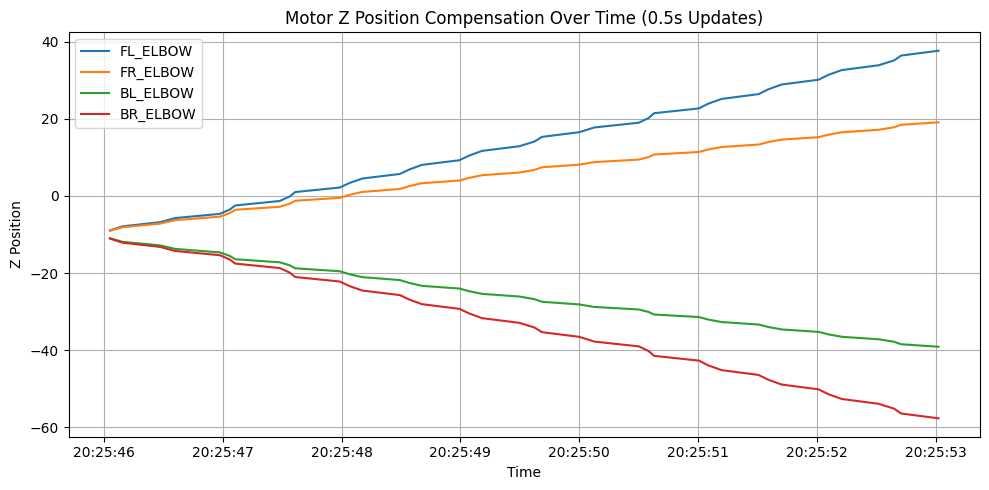

In [15]:
# --- Imports and Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from dataclasses import dataclass
from queue import Queue
import threading

# --- Data Models ---
@dataclass
class GyroData:
    roll: float  # Rotation around X (forward)
    pitch: float  # Rotation around Y (side)
    yaw: float  # Rotation around Z (vertical)

@dataclass
class MotorState:
    name: str
    z_position: float

# --- Constants ---
MOTOR_NAMES = ["FL_ELBOW", "FR_ELBOW", "BL_ELBOW", "BR_ELBOW"]

# --- Motor Initialization ---
def init_motor_states():
    return {name: MotorState(name, -10.0) for name in MOTOR_NAMES}

# --- Gyroscope Compensation Logic ---
def compensate_motors(gyro: GyroData, motors: dict, pitch_gain=0.2, roll_gain=0.1):
    updated = {}
    for name, state in motors.items():
        z = state.z_position

        if name.startswith("FL") or name.startswith("FR"):
            z -= pitch_gain * gyro.pitch
        if name.startswith("BL") or name.startswith("BR"):
            z += pitch_gain * gyro.pitch

        if name.startswith("FL") or name.startswith("BL"):
            z -= roll_gain * gyro.roll
        if name.startswith("FR") or name.startswith("BR"):
            z += roll_gain * gyro.roll

        updated[name] = MotorState(name, z)
    return updated

# --- Thread-safe gyro queue setup ---
gyro_queue = Queue(maxsize=1)
data_log = []
motor_states = init_motor_states()
lock = threading.Lock()

gyro_data_samples = [
    GyroData(-0.5629, -5.0092, 0.0666), GyroData(-0.6124, -5.0091, 0.0758), GyroData(-0.6621, -5.0020, 0.0919),
    GyroData(-0.7045, -4.9949, 0.1007), GyroData(-0.7469, -4.9878, 0.1095), GyroData(-0.7963, -4.9877, 0.1187),
    GyroData(-0.8386, -4.9736, 0.1274), GyroData(-0.8810, -4.9665, 0.1362), GyroData(-0.9234, -4.9664, 0.1451),
    GyroData(-0.9658, -4.9593, 0.1538), GyroData(-1.0081, -4.9522, 0.1626), GyroData(-1.0505, -4.9520, 0.1714),
    GyroData(-1.0859, -4.9449, 0.1799), GyroData(-1.8789, -4.8566, 0.3947), GyroData(-1.9003, -4.8564, 0.4027),
    GyroData(-1.9287, -4.8495, 0.4108), GyroData(-1.9500, -4.8492, 0.4187), GyroData(-1.9784, -4.8490, 0.4269),
    GyroData(-1.9997, -4.8418, 0.4346), GyroData(-2.0210, -4.8346, 0.4424), GyroData(-2.0423, -4.8344, 0.4503),
    GyroData(-2.0636, -4.8272, 0.4581), GyroData(-2.0779, -4.8270, 0.4657), GyroData(-2.0993, -4.8267, 0.4736),
    GyroData(-2.1206, -4.8265, 0.4815), GyroData(-2.1419, -4.8193, 0.4892), GyroData(-2.5481, -4.7580, 0.6661),
    GyroData(-2.5623, -4.7508, 0.6735), GyroData(-2.5696, -4.7506, 0.6808), GyroData(-2.5769, -4.7503, 0.6881),
    GyroData(-2.5912, -4.7501, 0.6957), GyroData(-2.5985, -4.7499, 0.7030), GyroData(-2.6126, -4.7498, 0.7036),
    GyroData(-2.6199, -4.7496, 0.7109), GyroData(-2.6342, -4.7493, 0.7184), GyroData(-2.6414, -4.7421, 0.7256),
    GyroData(-2.6557, -4.7418, 0.7332), GyroData(-2.6630, -4.7416, 0.7405), GyroData(-2.6700, -4.7416, 0.7408),
    GyroData(-2.8651, -4.7160, 0.8883), GyroData(-2.8724, -4.7157, 0.8956), GyroData(-2.8797, -4.7155, 0.9029),
    GyroData(-2.8870, -4.7152, 0.9102), GyroData(-2.8943, -4.7150, 0.9175), GyroData(-2.8946, -4.7148, 0.9245),
    GyroData(-2.9016, -4.7148, 0.9248), GyroData(-2.9019, -4.7146, 0.9318), GyroData(-2.9091, -4.7143, 0.9391),
    GyroData(-2.9164, -4.7141, 0.9464), GyroData(-2.9237, -4.7069, 0.9535), GyroData(-2.9310, -4.7066, 0.9608),
    GyroData(-2.9313, -4.7064, 0.9678), GyroData(-3.0216, -4.7090, 1.1187), GyroData(-3.0289, -4.7087, 1.1260),
    GyroData(-3.0362, -4.7085, 1.1333), GyroData(-3.0437, -4.7010, 1.1474), GyroData(-3.0510, -4.7008, 1.1547),
    GyroData(-3.0513, -4.7006, 1.1617), GyroData(-3.0516, -4.7004, 1.1687), GyroData(-3.0589, -4.7001, 1.1760),
    GyroData(-3.0591, -4.6929, 1.1828), GyroData(-3.0594, -4.6927, 1.1898), GyroData(-3.0668, -4.7512, 1.3528),
    GyroData(-3.0599, -4.7653, 1.3528), GyroData(-3.0604, -4.7579, 1.3667), GyroData(-3.0382, -4.7590, 1.3378)
    
]

# --- Gyroscope reading thread ---
def gyro_thread():
    for data in gyro_data_samples:
        if gyro_queue.full():
            gyro_queue.get()
        gyro_queue.put(data)
        time.sleep(0.1)  # simulate hardware sampling faster than compensation

# --- Compensation + motor command thread ---
def control_thread():
    global motor_states
    while True:
        if not gyro_queue.empty():
            gyro = gyro_queue.get()
            with lock:
                motor_states = compensate_motors(gyro, motor_states)
                record = {"timestamp": time.time(), "roll": gyro.roll, "pitch": gyro.pitch, "yaw": gyro.yaw}
                record.update({name: state.z_position for name, state in motor_states.items()})
                data_log.append(record)
        time.sleep(0.5)  # compensation rate

# --- Launch threads ---
gyro_t = threading.Thread(target=gyro_thread)
control_t = threading.Thread(target=control_thread)

gyro_t.start()
control_t.start()

gyro_t.join()
time.sleep(1.5)  # give some time for processing

# --- Create DataFrame from logs ---
df = pd.DataFrame(data_log)
display(df)

# --- Plot Result ---
plt.figure(figsize=(10, 5))
for motor in MOTOR_NAMES:
    plt.plot(pd.to_datetime(df['timestamp'], unit='s'), df[motor], label=motor)

plt.title("Motor Z Position Compensation Over Time (0.5s Updates)")
plt.xlabel("Time")
plt.ylabel("Z Position")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

,timestamp,roll,pitch,yaw,FL_ELBOW,FR_ELBOW,BL_ELBOW,BR_ELBOW
0,1.745267e+09,-0.5629,-5.0092,0.0666,-9.470935,-9.527225,-10.472775,-10.529065
1,1.745267e+09,-0.6124,-5.0091,0.0758,-8.407875,-8.586645,-11.413355,-11.592125
2,1.745267e+09,-0.7469,-4.9878,0.1095,-7.335625,-7.663775,-12.336225,-12.664375
3,1.745267e+09,-0.7963,-4.9877,0.1187,-6.258455,-6.745865,-13.254135,-13.741545
4,1.745267e+09,-0.8386,-4.9736,0.1274,-5.179875,-5.835005,-14.164995,-14.820125
5,1.745267e+09,-0.9234,-4.9664,0.1451,-4.637065,-5.384535,-14.615465,-15.362935
6,1.745267e+09,-0.9658,-4.9593,0.1538,-3.548625,-4.489255,-15.510745,-16.451375
7,1.745267e+09,-1.0081,-4.9522,0.1626,-2.457375,-3.599625,-16.400375,-17.542625
8,1.745267e+09,-1.0505,-4.9520,0.1714,-1.361925,-2.714275,-17.285725,-18.638075
9,1.745267e+09,-1.9003,-4.8564,0.4027,-0.200615,-1.933025,-18.066975,-19.799385


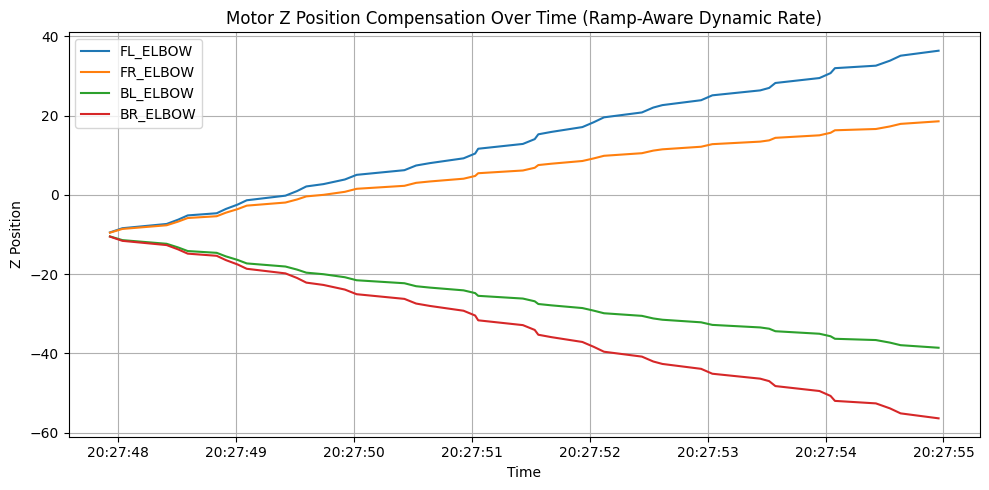

In [19]:
# --- Imports and Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from dataclasses import dataclass
from queue import Queue
import threading

# --- Data Models ---
@dataclass
class GyroData:
    roll: float  # Rotation around X (forward)
    pitch: float  # Rotation around Y (side)
    yaw: float  # Rotation around Z (vertical)

@dataclass
class MotorState:
    name: str
    z_position: float

# --- Constants ---
MOTOR_NAMES = ["FL_ELBOW", "FR_ELBOW", "BL_ELBOW", "BR_ELBOW"]

# --- Motor Initialization ---
def init_motor_states():
    return {name: MotorState(name, -10.0) for name in MOTOR_NAMES}

# --- Ramp Detection ---
def is_on_ramp(gyro: GyroData, pitch_thresh=2.0, roll_thresh=2.0):
    return abs(gyro.pitch) > pitch_thresh or abs(gyro.roll) > roll_thresh

# --- Gyroscope Compensation Logic ---
def compensate_motors(gyro: GyroData, motors: dict, pitch_gain=0.2, roll_gain=0.1):
    updated = {}
    for name, state in motors.items():
        z = state.z_position

        if name.startswith("FL") or name.startswith("FR"):
            z -= pitch_gain * gyro.pitch
        if name.startswith("BL") or name.startswith("BR"):
            z += pitch_gain * gyro.pitch

        if name.startswith("FL") or name.startswith("BL"):
            z -= roll_gain * gyro.roll
        if name.startswith("FR") or name.startswith("BR"):
            z += roll_gain * gyro.roll

        updated[name] = MotorState(name, z)
    return updated

# --- Thread-safe gyro queue setup ---
gyro_queue = Queue(maxsize=1)
data_log = []
motor_states = init_motor_states()
lock = threading.Lock()

gyro_data_samples = [
    GyroData(-0.5629, -5.0092, 0.0666), GyroData(-0.6124, -5.0091, 0.0758), GyroData(-0.6621, -5.0020, 0.0919),
    GyroData(-0.7045, -4.9949, 0.1007), GyroData(-0.7469, -4.9878, 0.1095), GyroData(-0.7963, -4.9877, 0.1187),
    GyroData(-0.8386, -4.9736, 0.1274), GyroData(-0.8810, -4.9665, 0.1362), GyroData(-0.9234, -4.9664, 0.1451),
    GyroData(-0.9658, -4.9593, 0.1538), GyroData(-1.0081, -4.9522, 0.1626), GyroData(-1.0505, -4.9520, 0.1714),
    GyroData(-1.0859, -4.9449, 0.1799), GyroData(-1.8789, -4.8566, 0.3947), GyroData(-1.9003, -4.8564, 0.4027),
    GyroData(-1.9287, -4.8495, 0.4108), GyroData(-1.9500, -4.8492, 0.4187), GyroData(-1.9784, -4.8490, 0.4269),
    GyroData(-1.9997, -4.8418, 0.4346), GyroData(-2.0210, -4.8346, 0.4424), GyroData(-2.0423, -4.8344, 0.4503),
    GyroData(-2.0636, -4.8272, 0.4581), GyroData(-2.0779, -4.8270, 0.4657), GyroData(-2.0993, -4.8267, 0.4736),
    GyroData(-2.1206, -4.8265, 0.4815), GyroData(-2.1419, -4.8193, 0.4892), GyroData(-2.5481, -4.7580, 0.6661),
    GyroData(-2.5623, -4.7508, 0.6735), GyroData(-2.5696, -4.7506, 0.6808), GyroData(-2.5769, -4.7503, 0.6881),
    GyroData(-2.5912, -4.7501, 0.6957), GyroData(-2.5985, -4.7499, 0.7030), GyroData(-2.6126, -4.7498, 0.7036),
    GyroData(-2.6199, -4.7496, 0.7109), GyroData(-2.6342, -4.7493, 0.7184), GyroData(-2.6414, -4.7421, 0.7256),
    GyroData(-2.6557, -4.7418, 0.7332), GyroData(-2.6630, -4.7416, 0.7405), GyroData(-2.6700, -4.7416, 0.7408),
    GyroData(-2.8651, -4.7160, 0.8883), GyroData(-2.8724, -4.7157, 0.8956), GyroData(-2.8797, -4.7155, 0.9029),
    GyroData(-2.8870, -4.7152, 0.9102), GyroData(-2.8943, -4.7150, 0.9175), GyroData(-2.8946, -4.7148, 0.9245),
    GyroData(-2.9016, -4.7148, 0.9248), GyroData(-2.9019, -4.7146, 0.9318), GyroData(-2.9091, -4.7143, 0.9391),
    GyroData(-2.9164, -4.7141, 0.9464), GyroData(-2.9237, -4.7069, 0.9535), GyroData(-2.9310, -4.7066, 0.9608),
    GyroData(-2.9313, -4.7064, 0.9678), GyroData(-3.0216, -4.7090, 1.1187), GyroData(-3.0289, -4.7087, 1.1260),
    GyroData(-3.0362, -4.7085, 1.1333), GyroData(-3.0437, -4.7010, 1.1474), GyroData(-3.0510, -4.7008, 1.1547),
    GyroData(-3.0513, -4.7006, 1.1617), GyroData(-3.0516, -4.7004, 1.1687), GyroData(-3.0589, -4.7001, 1.1760),
    GyroData(-3.0591, -4.6929, 1.1828), GyroData(-3.0594, -4.6927, 1.1898), GyroData(-3.0668, -4.7512, 1.3528),
    GyroData(-3.0599, -4.7653, 1.3528), GyroData(-3.0604, -4.7579, 1.3667), GyroData(-3.0382, -4.7590, 1.3378)
    
]

# --- Gyroscope reading thread ---
def gyro_thread():
    for data in gyro_data_samples:
        if gyro_queue.full():
            gyro_queue.get()
        gyro_queue.put(data)
        time.sleep(0.1)

# --- Compensation + motor command thread with dynamic rate ---
def control_thread():
    global motor_states
    while not gyro_queue.empty() or gyro_t.is_alive():
        if not gyro_queue.empty():
            gyro = gyro_queue.get()

            if is_on_ramp(gyro):
                pitch_gain = 0.1
                roll_gain = 0.05
                interval = 0.9  # slower for stability
            else:
                pitch_gain = 0.2
                roll_gain = 0.1
                interval = 0.5  # normal speed

            with lock:
                motor_states = compensate_motors(gyro, motor_states, pitch_gain, roll_gain)
                record = {"timestamp": time.time(), "roll": gyro.roll, "pitch": gyro.pitch, "yaw": gyro.yaw}
                record.update({name: state.z_position for name, state in motor_states.items()})
                data_log.append(record)

            time.sleep(interval)

# --- Launch threads ---
gyro_t = threading.Thread(target=gyro_thread)
control_t = threading.Thread(target=control_thread)

gyro_t.start()
control_t.start()

gyro_t.join()
control_t.join()

# --- Create DataFrame from logs ---
df = pd.DataFrame(data_log)
display(df)

# --- Plot Result ---
plt.figure(figsize=(10, 5))
for motor in MOTOR_NAMES:
    plt.plot(pd.to_datetime(df['timestamp'], unit='s'), df[motor], label=motor)

plt.title("Motor Z Position Compensation Over Time (Ramp-Aware Dynamic Rate)")
plt.xlabel("Time")
plt.ylabel("Z Position")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
